In [4]:
import tensorflow as tf
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.engine.functional import Functional
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.regularizers import l1, l2
import os

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning, prune_low_magnitude

from callbacks import all_callbacks


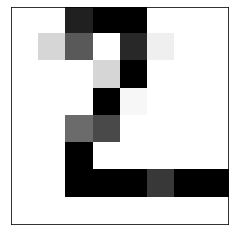

In [5]:
import MNIST_dataset as mnist

#Choose the final size of your image dataset
size_final = 8

data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)
test= data_zoom.x_test
train = data_zoom.x_train
ax = plt.subplot(1, 1 , 1)

plt.imshow(test[1].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [6]:
from tensorflow.keras.datasets import mnist as mnist
(_, y_train), (_, y_test) = mnist.load_data()


In [7]:
#lista contenente gli indici delle immagini campione nel Test Set del MNIST
#num_list[0] contiene l'indice dell'immagine di uno zero, num_list[1] di un uno e così via
#           0  1  2  3  4  5  6  7  8  9 
num_list = [3, 2, 1, 32,4, 15,21,0, 61,12]


#---------------------------------------------------------
#--FORMAT OF INPUT IMAGES FOR NN IN FPGA------------------
#----------- ap_fixed<6,0> -------------------------------
#---------------------------------------------------------

# last pixel              first pixel
#[0  1  0  0  0  0 | ... | 0  0  0  1  0  0]
# s  4  3  2  1  0         s  4  3  2  1  0 
#    2  2  2  2  2            2  2  2  2  2  


with open('TESTimg_downto_apfixed6.txt', 'w') as f:
    for index , num in enumerate(num_list):
        f.write(str(index)+ ': ')
        for i in np.flip(test[num]):
            #f.write('{:06d}'.format(int((bin(int(i*256/4))[2:]))))
            if i == 0.0:
                print(.00000)
                continue
            #print(i)
            print('{:06d}'.format(float_bin(number=i, places=5)))
        f.write('\n\n')


0.0
0.0
0.0


NameError: name 'float_bin' is not defined

## Find numbers from labels



Found 980 0s 
[3, 10, 13, 25, 28, 55, 69, 71, 101, 126, 136, 148, 157, 183, 188, 192, 194, 215, 246, 269, 271, 294, 296, 297, 305]


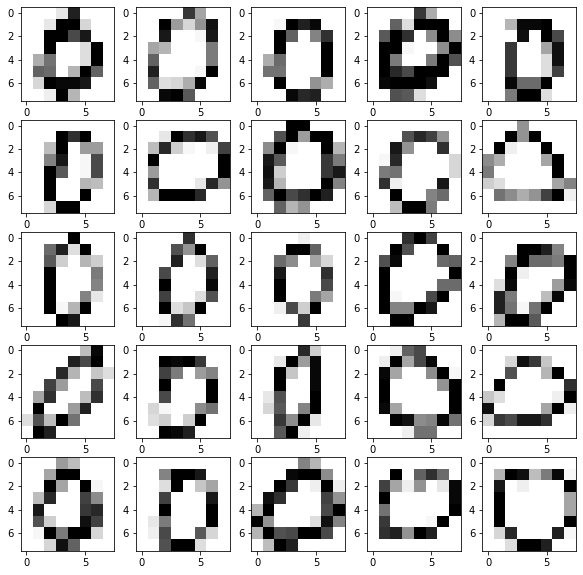

In [10]:
target_num = 0

indices = [i for i in range(len(test)) if y_test[i] == target_num]
print('Found', len(indices), str(target_num) + 's ')
print(indices[0:25])

fig = plt.figure(figsize=(10, 10))
j = 1
for i in indices[0:25]: 
    fig.add_subplot(5, 5, j)
    plt.imshow(test[i].reshape(size_final,size_final), cmap='gray_r')
    j+=1


## Generating file.txt with binary images from 0 to 10

In [16]:
dir = os.path.join("dataset")
if not os.path.exists(dir):
    os.mkdir(dir)

for target_num in range(0,10):
    indices = [i for i in range(len(test)) if y_test[i] == target_num]
    with open('dataset/TESTimg_' + str(target_num) + '_ap6.txt', 'w') as f:
        for index , num in enumerate(indices[0:100]):
            for i in np.flip(test[num]):
                f.write('{:016b}'.format((int(i*256))))
                print('{:016b}'.format((int(i*256))))
                print(i*256)
            f.write('\n')


0000000000000000
0.0
0000000000000000
0.0
0000000000000000
0.0
0000000001001000
72.0
0000000011111000
248.0
0000000000010000
16.0
0000000000000000
0.0
0000000000000000
0.0
0000000000000000
0.0
0000000000000000
0.0
0000000011100000
224.0
0000000011110000
240.0
0000000011110000
240.0
0000000011111000
248.0
0000000000101000
40.0
0000000000000000
0.0
0000000000000000
0.0
0000000010011000
152.0
0000000011111000
248.0
0000000001001000
72.0
0000000000000000
0.0
0000000010010000
144.0
0000000010011000
152.0
0000000000000000
0.0
0000000000000000
0.0
0000000011111000
248.0
0000000000100000
32.0
0000000000000000
0.0
0000000000000000
0.0
0000000010001000
136.0
0000000001010000
80.0
0000000000000000
0.0
0000000000000000
0.0
0000000011111000
248.0
0000000000100000
32.0
0000000000000000
0.0
0000000000000000
0.0
0000000011111000
248.0
0000000000000000
0.0
0000000000000000
0.0
0000000000000000
0.0
0000000000000000
0.0
0000000011100000
224.0
0000000010110000
176.0
0000000011111000
248.0
0000000011111000

In [42]:
#lista contenente gli indici delle immagini campione nel Test Set del MNIST
#num_list[0] contiene l'indice dell'immagine di uno zero, num_list[1] di un uno e così via

n_image_test = 100

#           0  1  2  3  4  5  6  7  8  9          
num_list = [3, 2, 1, 32,4, 15,21,0, 61,12] + [x for x in range(62,62 + n_image_test - 10)]

#num_list = [3]
with open('TESTimg_downto_apfixed6_100.txt', 'w') as f:
    for index , num in enumerate(num_list):
        #f.write('signal address_' + str(index) + ' : std_logic_vector((size-1) downto 0) := \n')
        for i in np.flip(test[num]):
            #f.write('{:016b}'.format(int((bin(int(i*256))[2:]))))
            f.write('{:016b}'.format((int(i*256))))
            print('{:016b}'.format((int(i*256))))
            print(i*256)
        f.write('\n')

#salvataggio dei true label associati alle immagini inserite nella FPGA
with open('TESTlabels_downto_apint6_100imgs.txt', 'w') as f:
    for index , num in enumerate(num_list):
        f.write('signal label_' + str(index) + ' : std_logic_vector(3 downto 0) :=  ')
        f.write('{:04d}'.format(int((bin(y_test_int[num])[2:]))))
        f.write('\n')

0000000000000000
0.0
0000000000000000
0.0
0000000000000000
0.0
0000000001001000
72.0
0000000011111000
248.0
0000000000010000
16.0
0000000000000000
0.0
0000000000000000
0.0
0000000000000000
0.0
0000000000000000
0.0
0000000011100000
224.0
0000000011110000
240.0
0000000011110000
240.0
0000000011111000
248.0
0000000000101000
40.0
0000000000000000
0.0
0000000000000000
0.0
0000000010011000
152.0
0000000011111000
248.0
0000000001001000
72.0
0000000000000000
0.0
0000000010010000
144.0
0000000010011000
152.0
0000000000000000
0.0
0000000000000000
0.0
0000000011111000
248.0
0000000000100000
32.0
0000000000000000
0.0
0000000000000000
0.0
0000000010001000
136.0
0000000001010000
80.0
0000000000000000
0.0
0000000000000000
0.0
0000000011111000
248.0
0000000000100000
32.0
0000000000000000
0.0
0000000000000000
0.0
0000000011111000
248.0
0000000000000000
0.0
0000000000000000
0.0
0000000000000000
0.0
0000000000000000
0.0
0000000011100000
224.0
0000000010110000
176.0
0000000011111000
248.0
0000000011111000